In [2]:
#good to start from tf env
#let's first import a few libraries that will be helpful to train a word2vec model
import pandas as pd
#!pip install dateparser
import dateparser 
from matplotlib import pyplot as plt 
import spacy 
import re
import numpy as np
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
pd.options.display.max_colwidth = 100

# We first start loading the data and preprocessing the textual **content**

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [108]:
#data=pd.read_csv('/content/drive/Shareddrives/Decoding Biases in AI - Fall 2021/Notebooks/covax-en-3000.csv')
#data=pd.read_csv('/Users/jpcointet/Dropbox/ts/data/covax_content_sample_2000_medium_sized.csv')
data=pd.read_csv('../all3/fb_tw_med_data.csv.gz')

In [109]:
#we build the full content of the article concatenating the article title + lede paragraph + article
#data['text']=data['title']+' '+data['extracted_text']
#data=data.astype(str)# making sure that the variable is the right type

In [110]:
data=data[data['origin']=='twitter']

In [111]:
data

,Unnamed: 0,id,date,text,source,origin
0,0,1436328269838700547,2021-09-10,"@EmmanuelMacron Transition agroécologique, ou plutôt sacrifice du modèle agricole Français à la ...",Simm,twitter
1,1,1436327620237529092,2021-09-10,#Béthune : un fumigène insecticide alerte les voisins et fait venir les secours http://www.laven...,L'Avenir de l'Artois,twitter
2,2,1436327427588993030,2021-09-10,Alors je récapitule :\nLa lavande c'est dangereux et les pesticides c'est génial ! j'ai bon à @E...,soraya,twitter
3,3,1436327130179284992,2021-09-10,#RappelProduit\nPREPAUSE 60 comprimés - LABORATOIRES INEBIOS\n\nRisques : Dépassement des limite...,RappelConso,twitter
4,4,1436326456695603203,2021-09-10,"#ESG Les politiques d’exclusions appliquées concernent : l’huile de #palme, les #OGM, la pâte à ...",Environnement Mag,twitter
...,...,...,...,...,...,...
1354747,1354978,1212167209704923136,2020-01-01,"@laurentchemla Très bonne et heureuse année 2020 à toi, Glyphosate et tous tes chats. https://tw...",Samia M'timet 😷 🤕 #Vaccinée 💉💉 🎉,twitter
1354748,1354979,1212165829292429313,2020-01-01,Glyphosate dans les urines : 67 plaintes déposées au tribunal de grande instance de Saint-Étienn...,BETAIL PLUS,twitter
1354749,1354980,1212163918149361664,2020-01-01,Pesticides.. que fait l'Europe?\n\nhttps://actu.fr/societe/pesticides-solitude-ces-agriculteurs-...,nicolas coorens,twitter
1354750,1354981,1212163422588149761,2020-01-01,Pesticides... que fait l'Europe? https://www.facebook.com/833238703/posts/10157750956368704/,nicolas coorens,twitter


In [112]:
#Washington Post, The New York Times (+ International Herald TRiubne), USA Today, Boston Globe, Wall Street Journal (Dow Jones & Company, Inc.)
#data['media_name'].value_counts()
data.source.value_counts()

L'important                5318
Hubert MESSMER 💉💉😷 🧘‍♂️    3356
Christian Rousseau         3100
aatea #jesuisvacciné       3053
Générations Futures        2355
                           ... 
FIN                           1
Vanessa Coste                 1
comic sans ns                 1
Rigoni di Asiago FRA          1
Le Petit Yoda Corse           1
Name: source, Length: 223153, dtype: int64

In [113]:
#mappring_newspaper={'Washington Post':'Washington Post','The New York Times Company':'New York Times','Dow Jones & Company, Inc.':'Wall Street Journal','USA Today Information Network':'USA Today','Boston Globe Media Partners LLC':'Boston Globe', 'International Herald Tribune':'Wall Street Journal','Dow Jones Company, Inc.':'Wall Street Journal','Dow Jones & Company, Inc. - Enterprise WSJ':'Wall Street Journal'}
#data['journal']=data['source'].map(mappring_newspaper)

In [114]:
data.sample(3)

,Unnamed: 0,id,date,text,source,origin
365976,365977,910059425926385664,2017-09-19,@remy67600 @GrainHedger @floguilloteau45 @Lionel_Jeanjeau Oui sauf que le glyphosate est vieux d...,Christophe Bitsch 🇪🇺🇩🇪,twitter
207146,207146,723527039920152577,2016-04-22,"Slip régional, pesticides et racket sur Internet : l'hebdo de la région #ALPC https://www.france...",France Bleu Gironde,twitter
996063,996294,1131172133265117185,2019-05-22,"@MathSRIsh @Qofficiel ça, c'est sur, en tant que herbicide, il est efficace... Et en tant que ca...",challier nicolas,twitter


In [115]:
#data['journal'].value_counts()

Date format can be automatially processed as time information by pandas if needed

In [116]:
#data['source']=data['media_name']

In [117]:
#dateparser.parse('8 juillet 2019, 15h02'), dateparser.parse('yesterday')

In [118]:
#we first turn the full date column into a datetime object
#data['publication_date']=data['date'].apply(dateparser.parse)
data['date'] = pd.to_datetime(data["date"])



In [119]:
#this phase simply consists in changing the index of the dataframe
data_time=data.set_index("date")
data_time.sample(3)

,Unnamed: 0,id,text,source,origin
date,,,,,
2019-04-11,1036772,1116321204959424512,"@vllentine @nicolas_rouet regardez le lien que j'ai mis, s'il y a un refus de l'utilisation des ...",aatea #jesuisvacciné,twitter
2018-12-06,1121406,1070812912619581442,"@OnceRebifera @moutoi2 Du Roundup, c’est bien aussi le roundup ! 🙃 https://twitter.com/MaevaAapo...",Maeva,twitter
2018-06-18,692403,1008788516258680832,"Ariège: En échange de votre urine, ils vous diront si vous êtes contaminés aux pesticides https:...",Daniel Chateigner,twitter


<AxesSubplot:xlabel='date'>

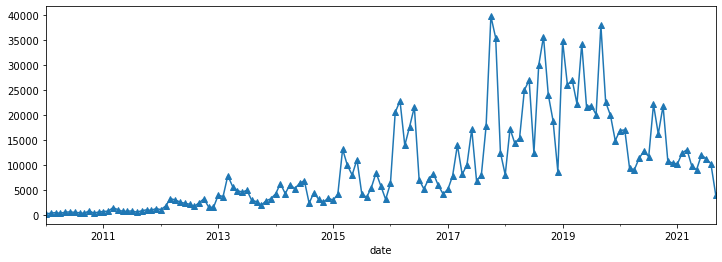

In [120]:
fig, axis = plt.subplots(figsize=(12, 4))
data_time['source'].resample('M').count().plot(style="-^",ax=axis)

In [121]:
data=data.sample(n=100000)

#Let's train our Word Embedding

In [122]:
#We use spacy to create a pipeline performing simple tasks with my text content, namely tokenizing the articles, removing non alphabetic strings,  lemmatizing, removing stop-words 

nlp = spacy.load('fr_core_news_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition and dependency parsing for speed
def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(txt)

brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in data['text'])
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=500)]



In [123]:
#we feed our dataframe with a new column "cleaned" and remove empty columns (if any)
data['cleaned']=txt
data=data.dropna(subset=['cleaned'])

In [124]:
print ("number of documents",len(data))

number of documents 100000


In [125]:
data.sample(3)

,Unnamed: 0,id,date,text,source,origin,cleaned
1177851,1178082,1042001113766141953,2018-09-18,"🖋️ Parmi les 63 députés qui ont refusé d'inscrire l'interdiction du glyphosate dans la loi, on ...",LEGENDRE Gérard,twitter,d put s refus inscrire interdiction glyphosate loi trouve lrem lr udi constructif modem commun...
63936,63936,1370857226433409024,2021-03-13,Pesticides : la Charente-Maritime est le plus gros acheteur de glyphosate #vin #wine #france #ch...,Journal du Vin,twitter,pesticide charente maritime gros acheteur glyphosate vin wine france cher https journal vin com ...
1348896,1349127,1216299289145749506,2020-01-12,@isidornazareth @lemondefr Les touliettes c'est l'Union Européenne. Les pesticides en hausse au ...,Schneiderduf,twitter,isidornazareth lemondefr touliette union europ enne pesticide hausse niveau achat bier t inter...


We are using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences. https://radimrehurek.com/gensim/models/phrases.html



In [126]:
sent = [row.split() for row in data['cleaned']]
phrases = Phrases(sent, min_count=25, progress_per=10000)



2022-04-27 14:48:28,844 : INFO : collecting all words and their counts
2022-04-27 14:48:28,845 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2022-04-27 14:48:28,970 : INFO : PROGRESS: at sentence #10000, processed 216590 words and 137507 word types
2022-04-27 14:48:29,099 : INFO : PROGRESS: at sentence #20000, processed 431509 words and 236840 word types
2022-04-27 14:48:29,229 : INFO : PROGRESS: at sentence #30000, processed 646433 words and 326393 word types
2022-04-27 14:48:29,366 : INFO : PROGRESS: at sentence #40000, processed 861595 words and 409470 word types
2022-04-27 14:48:29,503 : INFO : PROGRESS: at sentence #50000, processed 1078638 words and 488069 word types
2022-04-27 14:48:29,644 : INFO : PROGRESS: at sentence #60000, processed 1296403 words and 562547 word types
2022-04-27 14:48:29,786 : INFO : PROGRESS: at sentence #70000, processed 1510922 words and 633794 word types
2022-04-27 14:48:29,934 : INFO : PROGRESS: at sentence #80000, processed 172

In [127]:
bigram = Phraser(phrases)
sentences = bigram[sent]


2022-04-27 14:48:30,234 : INFO : exporting phrases from Phrases<834137 vocab, min_count=25, threshold=10.0, max_vocab_size=40000000>
2022-04-27 14:48:31,032 : INFO : FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<2712 phrases, min_count=25, threshold=10.0> from Phrases<834137 vocab, min_count=25, threshold=10.0, max_vocab_size=40000000> in 0.80s', 'datetime': '2022-04-27T14:48:31.032490', 'gensim': '4.1.2', 'python': '3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:14) \n[Clang 12.0.1 ]', 'platform': 'macOS-12.3.1-arm64-arm-64bit', 'event': 'created'}


In [128]:
w2v_model = Word2Vec(min_count=25,
                     window=5,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=2)
w2v_model.build_vocab(sentences, progress_per=10000)


2022-04-27 14:48:31,054 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=300, alpha=0.03)', 'datetime': '2022-04-27T14:48:31.054743', 'gensim': '4.1.2', 'python': '3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:14) \n[Clang 12.0.1 ]', 'platform': 'macOS-12.3.1-arm64-arm-64bit', 'event': 'created'}
2022-04-27 14:48:31,055 : INFO : collecting all words and their counts
2022-04-27 14:48:31,055 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-04-27 14:48:31,164 : INFO : PROGRESS: at sentence #10000, processed 183633 words, keeping 27527 word types
2022-04-27 14:48:31,269 : INFO : PROGRESS: at sentence #20000, processed 365354 words, keeping 41368 word types
2022-04-27 14:48:31,376 : INFO : PROGRESS: at sentence #30000, processed 547841 words, keeping 52754 word types
2022-04-27 14:48:31,482 : INFO : PROGRESS: at sentence #40000, processed 730575 words, keeping 62879 word types
2022-04-27 14:48:31,592 : INFO : PROGRE

In [129]:

w2v_model.train(sentences, total_examples=w2v_model.corpus_count,  epochs=10, report_delay=1)



2022-04-27 14:48:32,239 : INFO : Word2Vec lifecycle event {'msg': 'training model with 2 workers on 8012 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=5 shrink_windows=True', 'datetime': '2022-04-27T14:48:32.239338', 'gensim': '4.1.2', 'python': '3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:14) \n[Clang 12.0.1 ]', 'platform': 'macOS-12.3.1-arm64-arm-64bit', 'event': 'train'}
2022-04-27 14:48:33,259 : INFO : EPOCH 1 - PROGRESS: at 41.57% examples, 343704 words/s, in_qsize 3, out_qsize 0
2022-04-27 14:48:34,267 : INFO : EPOCH 1 - PROGRESS: at 83.47% examples, 347240 words/s, in_qsize 3, out_qsize 0
2022-04-27 14:48:34,658 : INFO : worker thread finished; awaiting finish of 1 more threads
2022-04-27 14:48:34,662 : INFO : worker thread finished; awaiting finish of 0 more threads
2022-04-27 14:48:34,662 : INFO : EPOCH - 1 : training on 1831808 raw words (840876 effective words) took 2.4s, 348016 effective words/s
2022-04-27 14:48:35,674 : IN

(8414419, 18318080)

# Test the resulting embedding

the method *similarity* allows to measure the cosine between two word vectors.

The method *most_similar* lists the 10 closest words to a given target word, it also allows to play the "analogy game"

In [130]:
words = list(w2v_model.wv.index_to_key)
words

['pesticide',
 'glyphosate',
 'd',
 'com',
 'l',
 'https_twitter',
 'http',
 's',
 'https_www',
 'fr',
 'c',
 'statu_photo',
 'm',
 'html',
 'e',
 'https',
 't',
 'france',
 'glyphosat',
 'abeille',
 'r',
 'bio',
 'insecticide',
 'ly',
 'contre',
 'interdire',
 'monsanto',
 'n_onicotino',
 'http_bit',
 'non',
 'interdiction',
 'www',
 'n',
 'status_photo',
 'agriculture',
 'roundup',
 'status',
 'bien',
 'faire',
 'agriculteur',
 'article',
 'sant',
 'an',
 "l_'",
 'herbicide',
 'pr',
 'produit',
 'falloir',
 'environnement',
 'europe',
 'ogm',
 "'",
 'http_fb',
 'j',
 'vouloir',
 'p',
 'org',
 'statu',
 'bon',
 'twitter',
 'monde',
 're',
 'cancer',
 'neonicotinoide',
 'utilisation',
 'gouvernement',
 'eau',
 'nouveau',
 'heure',
 'b',
 'qu',
 'lemonde_fr',
 'voir',
 'anti',
 'f',
 'tr_s',
 'pouvoir',
 'apr_s',
 'interdir',
 'utm_medium',
 'politique',
 'oui',
 'it',
 'chlord_cone',
 'usage',
 'www_lemonde',
 'savoir',
 'php',
 'mettre',
 'utm_source',
 'tude',
 'passer',
 'tre',
 'ue

In [140]:
w2v_model.wv.similarity('glyphosate', 'pesticide') #The cosine similarity can range from -1 to +1


-0.002238358

In [141]:
w2v_model.wv.most_similar('europe')

[('http_eur', 0.6303067803382874),
 ('ue', 0.615733802318573),
 ('bayer_porte', 0.6107854843139648),
 ('vouloir_autoriser', 0.5900305509567261),
 ('exporter', 0.5893661379814148),
 ('allemagn', 0.5771244168281555),
 ('lunion_europeenn', 0.576347827911377),
 ('qualite_filier', 0.570594847202301),
 ('reduir_controle', 0.5701566338539124),
 ('renouvel', 0.5593519806861877)]

In [142]:
#w2v_model.wv.most_similar('harvard')

In [143]:
w2v_model.wv.most_similar('sante')

[('lefigaro', 0.7826823592185974),
 ('topsante', 0.7650046348571777),
 ('medecine', 0.7498327493667603),
 ('allodocteur', 0.7163767218589783),
 ('fraise_vendre', 0.6955114006996155),
 ('psychomedier', 0.6889169216156006),
 ('saveur_sante', 0.6867979764938354),
 ('www_comparateurmedicamer', 0.680696964263916),
 ('maladie_grave', 0.6791743040084839),
 ('qc_ca', 0.6672009229660034)]

In [144]:
w2v_model.wv.most_similar('environnement')

[('www_ledevoir', 0.6693887114524841),
 ('pesticides', 0.6303040385246277),
 ('ethiqu', 0.6296125054359436),
 ('ledevoir', 0.6117292046546936),
 ('actualiter', 0.6080703139305115),
 ('infos_climat', 0.591728687286377),
 ('sant', 0.5815549492835999),
 ('biodiversite', 0.5789602398872375),
 ('humanite', 0.5756170153617859),
 ('qualite', 0.5672080516815186)]

In [145]:
w2v_model.wv.most_similar('rse')

[('agricultur_isr', 0.9720407724380493),
 ('novethic_fr', 0.8777121305465698),
 ('isr_rse', 0.8750220537185669),
 ('fr_empreindre', 0.8714316487312317),
 ('actualit_environnement', 0.8671841621398926),
 ('www_novethic', 0.8651548624038696),
 ('novethic', 0.7783938050270081),
 ('environnement_agricultur', 0.6626186370849609),
 ('industrie_agroalimentaire', 0.5754104852676392),
 ('entreprise_finance', 0.5673340559005737)]

In [146]:
#w2v_model.wv.similarity('fake','hydroxychloroquine')

In [147]:
#w2v_model.wv.most_similar('fake')

In [148]:
w2v_model.wv.most_similar('fille',topn =20)

[('fils', 0.8497145771980286),
 ('handicap', 0.8007912635803223),
 ('maman', 0.7719074487686157),
 ('parent', 0.7524767518043518),
 ('mere', 0.7239636182785034),
 ('naissance', 0.7003369331359863),
 ('explosion', 0.6914002895355225),
 ('cancers', 0.6774356365203857),
 ('malformation', 0.6760836839675903),
 ('mourir', 0.6752330660820007),
 ('froid', 0.6699117422103882),
 ('enfant', 0.6692668795585632),
 ('meurt', 0.6676301956176758),
 ('ain', 0.6675733327865601),
 ('gar', 0.6574674248695374),
 ('man', 0.6502112150192261),
 ('poumon', 0.6380364894866943),
 ('femme', 0.6331920623779297),
 ('respire', 0.6300638914108276),
 ('diatrique', 0.6285786628723145)]

Now Playing the analogy game

In [149]:
#playing the analogy game 
w2v_model.wv.most_similar(positive=['france', 'berlin'], negative=['paris'])


KeyError: "Key 'berlin' not present"

In [150]:
#w2v_model.wv.most_similar(positive=["chine",'pfizer' ], negative=['unis'])


In [151]:
#w2v_model.wv.most_similar(positive=['moderna_pfizer',"united_kingdom" ], negative=['united_states'])



In [152]:
## let's define the cosine similarity as a function
import numpy as np
from numpy.linalg import norm

def cosine_similarity(vector1,vector2):
    result = np.dot(vector1, vector2)/(norm(vector1)*norm(vector2))
    return result

In [179]:
## let's define an axis
w1 = "sante"
w2 = "environnement"

#w1 = "sante"
#w2 = "environnement"


axis = w2v_model.wv.get_vector(w2) - w2v_model.wv.get_vector(w1)

## choose some words to project on it
#words = ["jean","philippe","michel","elisabeth", "roselyne_bachelot", "jean", "camille",'louise', "camille","femme","homme"]
words = ['chlordecone','roundup','neonicotinoide','sdhi','abeille','glyphosate','ogm']

projections,wordss = [],[]
for word in words:
    try:
        wordvector = w2v_model.wv.get_vector(word)
        projections.append(cosine_similarity(wordvector,axis))
        wordss.append(word)
    except:
        pass

In [180]:
#w2v_model.wv.get_vector('linky')

In [181]:
projections

[-0.20590039,
 -0.27799168,
 0.059457127,
 0.033764537,
 0.11474383,
 -0.037826564,
 -0.020954734]

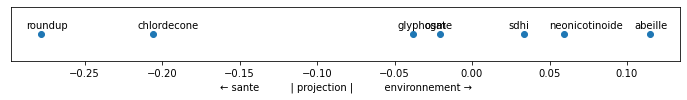

In [182]:
## plot the result
fig = plt.figure(figsize=(12,1))
ax = fig.add_subplot(1,1,1)
ax.scatter(projections,y=np.zeros(len(projections)))
for i in range(len(projections)):
    plt.text(projections[i]-0.01,0.01,wordss[i])
ax.set_xlabel(f"← {w1}          | projection |          {w2} →")
ax.set_yticks([])
plt.show()

Projecting word vectors onto certain dimensions

we use the scalar product to perform such projection

In [63]:
man_words=["son","father","man","boy","male","brother"]
woman_words=["daughter","mother","woman","girl","female","sister"]
man_vs_woman=np.zeros(300)
for x in man_words:
  man_vs_woman = man_vs_woman + w2v_model.wv[x] / np.sqrt(w2v_model.wv[x] @ w2v_model.wv[x])
for x in woman_words:
  man_vs_woman = man_vs_woman - w2v_model.wv[x] / np.sqrt(w2v_model.wv[x] @ w2v_model.wv[x])
man_vs_woman = man_vs_woman / np.sqrt(man_vs_woman @ man_vs_woman)

KeyError: "Key 'son' not present"

In [ ]:
def project(man_vs_woman,word):
  return man_vs_woman @ w2v_model.wv[word] / np.sqrt(w2v_model.wv[word] @ w2v_model.wv[word])

In [ ]:
project(man_vs_woman,'teacher')

-0.3702844456372121

In [ ]:
project(man_vs_woman,'surgeon')

0.33171054055115284

In [ ]:
occupation=["teacher","author","broker","baker","surgeon","artist","dentist","athlete","manager","secretary","economist","clerk","doctor","judge","physician","lawyer","artist","instructor","dancer","inspector","musician","soldier","professor","nurse","sailor","architect","administrator","scientist"]
for job in occupation:
    print(job,'\t',project(man_vs_woman,job))


teacher 	 -0.3702844456372121
author 	 0.1932642129019581
broker 	 -0.05868376258310805
baker 	 -0.03474305222013565
surgeon 	 0.33171054055115284
artist 	 -0.11106717894484198
dentist 	 -0.022138574311971075
athlete 	 -0.19679533074062225
manager 	 -0.007347438089954973
secretary 	 0.07644420965927512
economist 	 0.050847920757965244
clerk 	 -0.2602823085681751
doctor 	 0.18572088811722706
judge 	 -0.16244452197004974
physician 	 0.18317368320166055
lawyer 	 0.09725298105552059
artist 	 -0.11106717894484198
instructor 	 -0.11161066086486048
dancer 	 -0.21659395335899398
inspector 	 0.0030362802559405822
musician 	 -0.04354022949521447
soldier 	 0.18383457644729073
professor 	 0.01504237410107816
nurse 	 0.06648982881780562
sailor 	 0.2622136308411092
architect 	 0.1026315607436855
administrator 	 -0.0792633858520707
scientist 	 0.19670494285160062


# Final Exercise: can you identify discriminatory trends toward asian people in the first months of the pandemics ?